In [3]:
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import glob
import datetime

%matplotlib inline

In [4]:
date_start = '2017-01-01'
date_end   = '2017-04-23'

df = pd.read_csv(
    './data/cur.zentrum.nibelungenbruecke.traffic.risc-software.at.csv', 
    parse_dates = [0], 
    index_col = 0
)
df = df[date_start:date_end]
print df.columns

Index([u'delay', u'average_speed', u'delayed_average_speed', u'total_distance',
       u'total_duration', u'total_duration_in_traffic', u'day', u'dow', u'hod',
       u'working_day'],
      dtype='object')


In [6]:
df.delay = df.delay / 60.0
df.total_duration = df.total_duration / 60.0
df.total_duration_in_traffic = df.total_duration_in_traffic / 60.0

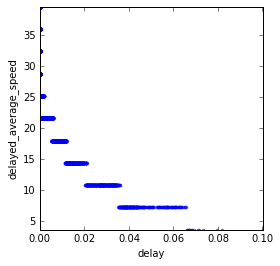

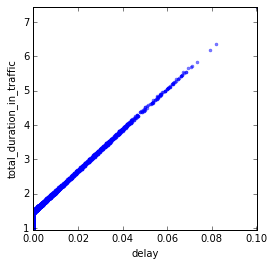

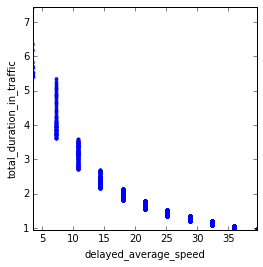

In [8]:
features = [u'delay', u'delayed_average_speed', u'total_duration_in_traffic']
for i,fx in enumerate(features) :
    for j,fy in enumerate(features) :
        if fx == fy or i > j : continue
        plt.figure(figsize=(4,4))
        plt.plot(df[fx], df[fy], '.', alpha = 0.5)
        plt.xlim([df[fx].min(), df[fx].max()])
        plt.ylim([df[fy].min(), df[fy].max()])
        plt.xlabel(fx)
        plt.ylabel(fy)
        plt.show()

In [9]:
data =  df[features]

In [10]:
import numpy as np

def organize_data(to_forecast, window, horizon):
    """
     Input:
      to_forecast, univariate time series organized as numpy array
      window, number of items to use in the forecast window
      horizon, horizon of the forecast
     Output:
      X, a matrix where each row contains a forecast window
      y, the target values for each row of X
    """
    shape   = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast, 
                                        shape=shape, 
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

k = 144  # number of previous observations to use
h = 6   # forecast horizon
X,y = organize_data(data.total_duration_in_traffic.values, k, h)

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
m = 2880 # number of samples to take in account
regressors = {
    'LinearRegression' : LinearRegression(normalize=True),
    'SVR' : svm.SVR(kernel='rbf',C=100,gamma=.001),
    'SGD' : SGDRegressor(),
    'KNN' : KNeighborsRegressor(),
    'GBR' : GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0, loss='ls'),
    'GPR' : GaussianProcessRegressor()
}

def mape(ypred, ytrue):
    """ returns the mean absolute percentage error """
    idx = ytrue != 0.0
    return 100*np.mean(np.abs(ypred[idx]-ytrue[idx])/ytrue[idx])

for i,c in regressors.items():
    print 'fitting -- ', i , 
    c.fit(X[:m], y[:m])
    print ' : error is %0.2f%%' % mape(c.predict(X[m:]),y[m:])

fitting --  KNN  : error is 13.01%
fitting --  GBR  : error is 14.20%
fitting --  LinearRegression  : error is 12.69%
fitting --  SVR  : error is 11.74%
fitting --  SGD  : error is 11.96%
fitting --  GPR  : error is 75.53%


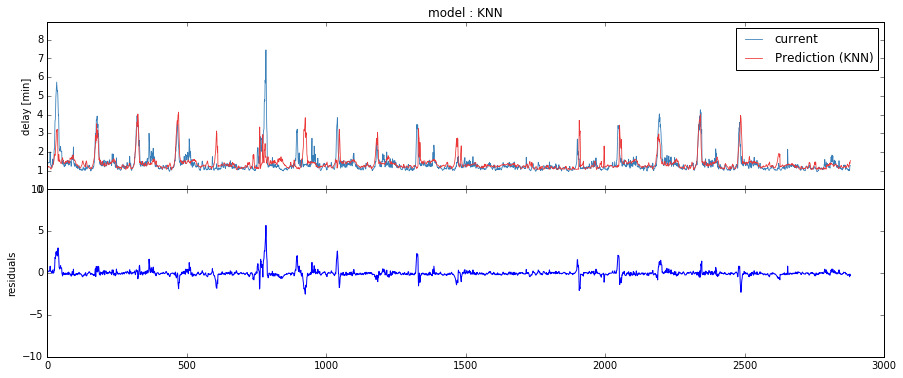

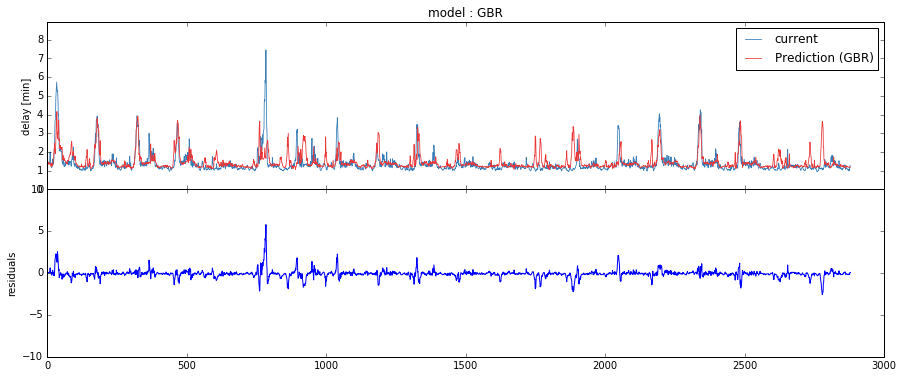

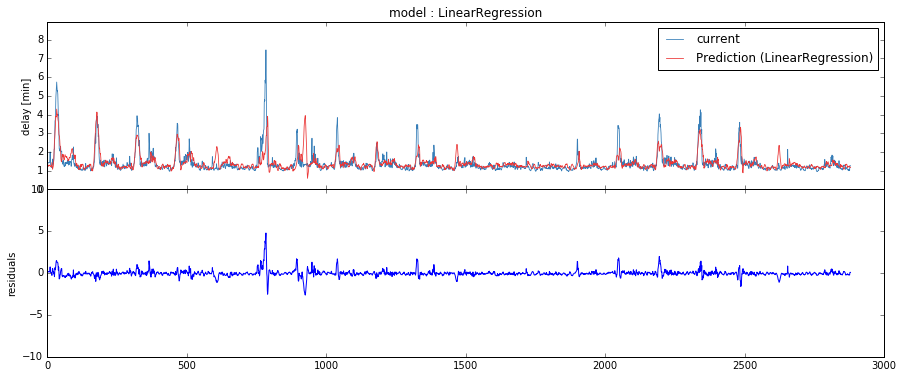

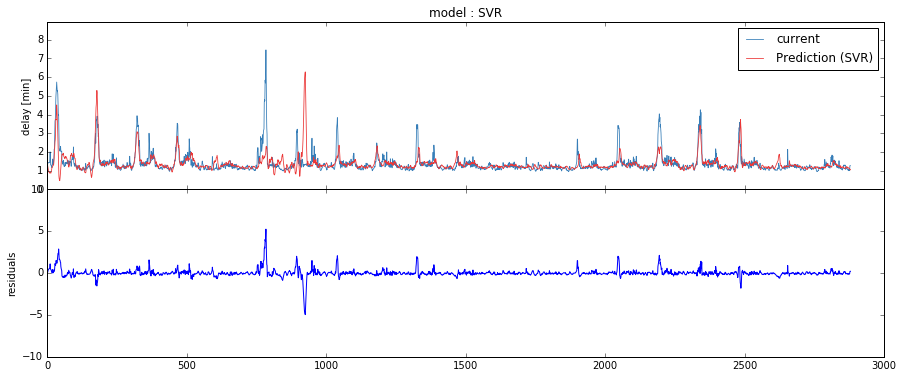

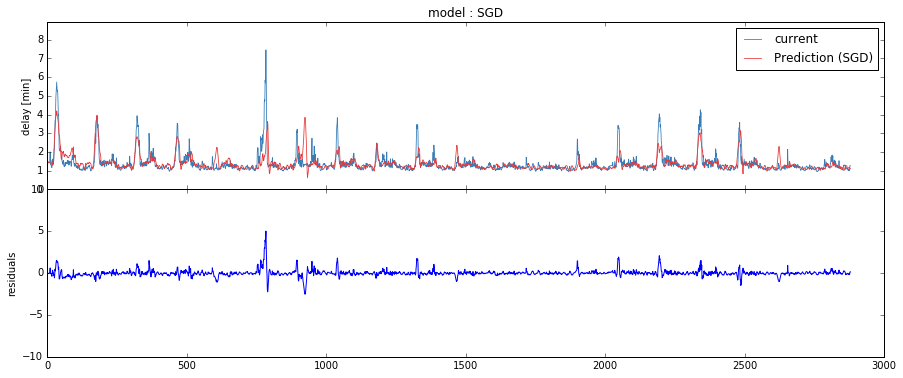

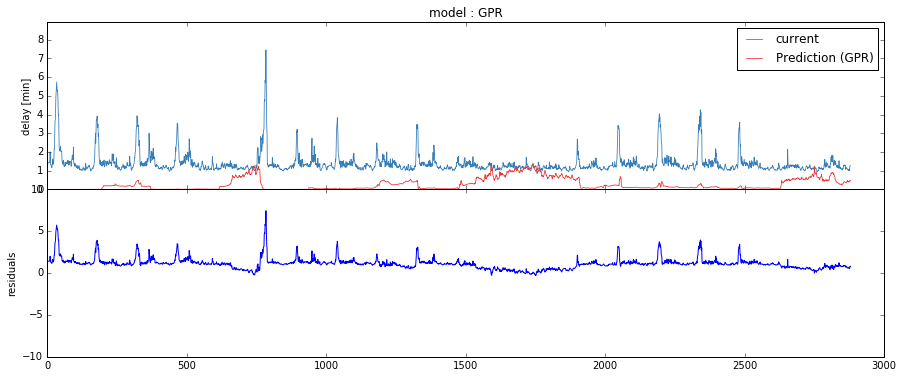

In [41]:
for i,c in regressors.items(): 
    f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, figsize=(15,6))
    ax1.set_title('model : %s' % i)
    ax1.plot(y[-2880:], label='current', color='#377EB8', linewidth=0.8)
    ax1.plot(c.predict(X[-2880:]), '-', color='#EB3737', linewidth=0.8, label='Prediction (%s)'%i)
    ax1.legend(loc='upper right')
    ax1.set_ylabel('delay [min]')
    ax1.set_ylim([0,y[-2880:].max()*1.2])
    ax2.plot((y[-2880:] - c.predict(X[-2880:])) , label ='')
    ax2.set_ylabel('residuals')
    ax2.set_ylim([-10,10])
    f.subplots_adjust(hspace=0)
    plt.show()